In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
# cwd = os.getcwd()
# cwd

In [3]:
# raw_csv_data = pd.read_csv(cwd + '\TG.csv')
raw_csv_data = pd.read_csv('WB.csv')
df=raw_csv_data.copy()

In [4]:
para = 'Decreased'

In [5]:
df.Date.describe()

count           115
unique          115
top       29-Mar-20
freq              1
Name: Date, dtype: object

In [6]:
df

,Date,Confirmed,Recovered,Decreased
0,14-Mar-20,0,0,0
1,15-Mar-20,0,0,0
2,16-Mar-20,0,0,0
3,17-Mar-20,1,0,0
4,18-Mar-20,0,0,0
...,...,...,...,...
110,02-Jul-20,649,509,16
111,03-Jul-20,669,534,18
112,04-Jul-20,743,595,19
113,05-Jul-20,895,545,21


In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.head()

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,0,0,0
1,2020-03-15,0,0,0
2,2020-03-16,0,0,0
3,2020-03-17,1,0,0
4,2020-03-18,0,0,0


In [9]:
df

,Date,Confirmed,Recovered,Decreased
0,2020-03-14,0,0,0
1,2020-03-15,0,0,0
2,2020-03-16,0,0,0
3,2020-03-17,1,0,0
4,2020-03-18,0,0,0
...,...,...,...,...
110,2020-07-02,649,509,16
111,2020-07-03,669,534,18
112,2020-07-04,743,595,19
113,2020-07-05,895,545,21


In [10]:
df.set_index('Date', inplace=True)
df.index.freq = 'D'

In [11]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,0,0,0
2020-03-15,0,0,0
2020-03-16,0,0,0
2020-03-17,1,0,0
2020-03-18,0,0,0
...,...,...,...
2020-07-02,649,509,16
2020-07-03,669,534,18
2020-07-04,743,595,19


In [12]:
# df.Date.describe()

In [13]:
df

,Confirmed,Recovered,Decreased
Date,,,
2020-03-14,0,0,0
2020-03-15,0,0,0
2020-03-16,0,0,0
2020-03-17,1,0,0
2020-03-18,0,0,0
...,...,...,...
2020-07-02,649,509,16
2020-07-03,669,534,18
2020-07-04,743,595,19


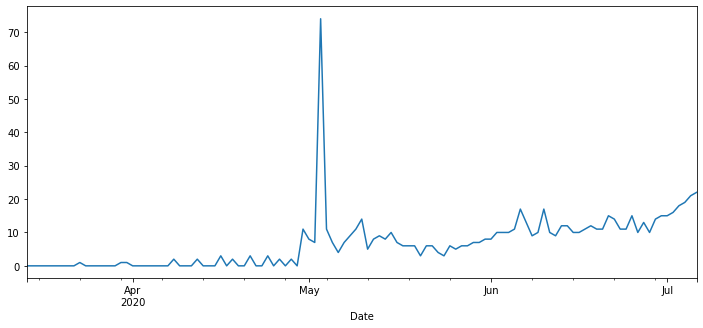

In [14]:
df[para].plot(figsize=(12,5));

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [16]:
adf_test(df[para])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.909787
p-value                   0.044222
# lags used               2.000000
# observations          112.000000
critical value (1%)      -3.490131
critical value (5%)      -2.887712
critical value (10%)     -2.580730
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


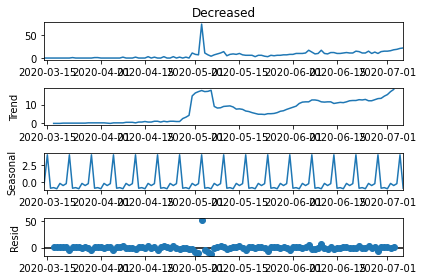

In [17]:
result = seasonal_decompose(df[para])
result.plot();

In [18]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df[para],k_diff=2)

In [19]:
adf_test(df['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.980177e+00
p-value                 1.846519e-07
# lags used             1.100000e+01
# observations          1.010000e+02
critical value (1%)    -3.496818e+00
critical value (5%)    -2.890611e+00
critical value (10%)   -2.582277e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [20]:
# stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
#                           max_p=4, max_q=4,
#                           seasonal=False,
#                           d=None, trace=True,
#                           error_action='ignore',   # we don't want to know if an order does not work
#                           suppress_warnings=True,  # we don't want convergence warnings
#                           stepwise=True)           # set to stepwise

# stepwise_fit.summary()

stepwise_fit = auto_arima(df[para], start_p=0, start_q=0,
                          max_p=4, max_q=4,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,           # set to stepwise
                         frequency=12)

stepwise_fit.summary()

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=827.789, BIC=833.261, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=801.821, BIC=810.030, Time=0.028 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=776.287, BIC=784.496, Time=0.052 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=825.841, BIC=828.578, Time=0.009 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=774.946, BIC=785.890, Time=0.152 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=775.474, BIC=786.418, Time=0.150 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=779.372, BIC=793.053, Time=0.152 seconds
Total fit 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -383.473
Date:                Wed, 15 Jul 2020   AIC                            774.946
Time:                        23:57:39   BIC                            785.890
Sample:                             0   HQIC                           779.387
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1245      0.057      2.187      0.029       0.013       0.236
ar.L1          0.1731      0.111      1.556      0.120      -0.045       0.391
ma.L1         -0.9999     14.241     -0.070      0.944     -28.912      26.912
sigma2        47.0523    668.098      0.070      0.944   -1262.396    1356.501
===================================================================================
Ljung-Box (Q):                       13.54   Jarque-Bera (JB):             34227.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                             8.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        86.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
train = df.iloc[:104]
test = df.iloc[104:111]

In [22]:
# from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
# model = ARIMA(train[para],order=(1, 1, 1))
model = SARIMAX(train[para],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Decreased   No. Observations:                  104
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -324.465
Date:                            Wed, 15 Jul 2020   AIC                            658.930
Time:                                    23:57:40   BIC                            671.485
Sample:                                03-14-2020   HQIC                           663.995
                                     - 06-25-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1011      0.159      0.635      0.525      -0.211       0.413
ma.L1         -0.8821      0.111     -7.953      0.000      -1.100      -0.665
ar.S.L12       0.0335      0.106      0.317      0.751      -0.173       0.241
ma.S.L12      -0.9992     46.634     -0.021      0.983     -92.400      90.402
sigma2        54.5682   2540.046      0.021      0.983   -4923.830    5032.966
===================================================================================
Ljung-Box (Q):                       13.55   Jarque-Bera (JB):             10282.36
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.65   Skew:                             6.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        53.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# Obtain predicted values
# start=len(train)
# end=len(train)+len(test)-1

start=104
end=110

# predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,1,12) Predictions')

# df['forecast'] = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,2,1) Predictions')

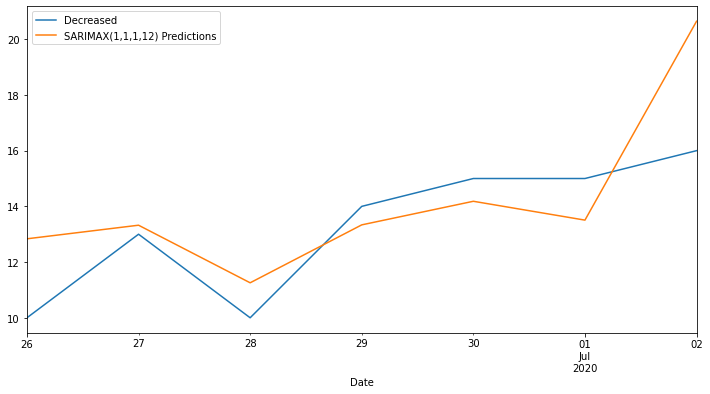

In [25]:
# Obtain predicted values
ax = test[para].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
# df['forecast'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [26]:
# # from statsmodels.tools.eval_measures import rmse
# from statsmodels.tools.eval_measures import mse

# error = mse(test[para], predictions)
# # print(f'ARIMA(2,2,1) RMSE Error: {error:11.10}')
# # print(f'ARIMA(2,2,1) MSE Error: {error:11.10}')
# print(f'SARIMAX(2,2,1,3) MSE Error: {error:11.10}')

In [27]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(test[para], predictions)
MAE

1.719385369130284

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# per_MAPE = (MAPE/sum(test[para]))*100
per_MAPE = mean_absolute_percentage_error(test[para], predictions)
print(per_MAPE,'%')

13.226805543674672 %


In [29]:
type(predictions)

pandas.core.series.Series

In [30]:
df['forecast'] = predictions
df

,Confirmed,Recovered,Decreased,d1,forecast
Date,,,,,
2020-03-14,0,0,0,NaN,NaN
2020-03-15,0,0,0,NaN,NaN
2020-03-16,0,0,0,0.0,NaN
2020-03-17,1,0,0,0.0,NaN
2020-03-18,0,0,0,0.0,NaN
...,...,...,...,...,...
2020-07-02,649,509,16,1.0,20.645726
2020-07-03,669,534,18,1.0,NaN
2020-07-04,743,595,19,-1.0,NaN


In [31]:
dictt = {f'{para}':test[para],f'Predicted_{para}':predictions}
dictt

{'Decreased': Date
 2020-06-26    10
 2020-06-27    13
 2020-06-28    10
 2020-06-29    14
 2020-06-30    15
 2020-07-01    15
 2020-07-02    16
 Freq: D, Name: Decreased, dtype: int64,
 'Predicted_Decreased': 2020-06-26    12.835393
 2020-06-27    13.323360
 2020-06-28    11.255856
 2020-06-29    13.335925
 2020-06-30    14.182661
 2020-07-01    13.506052
 2020-07-02    20.645726
 Freq: D, Name: SARIMAX(1,1,1,12) Predictions, dtype: float64}

In [32]:
predicted_df = pd.DataFrame(dictt)
predicted_df

,Decreased,Predicted_Decreased
Date,,
2020-06-26,10,12.835393
2020-06-27,13,13.323360
2020-06-28,10,11.255856
2020-06-29,14,13.335925
2020-06-30,15,14.182661
2020-07-01,15,13.506052
2020-07-02,16,20.645726


In [33]:
# predicted_df.to_csv('Predicted_WB.csv')
predicted_csv = pd.read_csv('Predicted_WB.csv')

predicted_csv.Date = pd.to_datetime(predicted_csv.Date)
predicted_csv.set_index('Date', inplace=True)
predicted_csv.index.freq = 'D'
# print(predicted_csv)
# predicted_csv = pd.concat([predicted_csv,predicted_df],axis=1,ignore_index=True)
predicted_csv = pd.merge(predicted_csv, predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(predicted_csv)
predicted_csv.to_csv('Predicted_WB.csv')

            Confirmed  Predicted_Confirmed  Recovered  Predicted_Recovered  \
Date                                                                         
2020-06-26        542           494.077396        345           481.663466   
2020-06-27        521           585.479176        254           468.964824   
2020-06-28        572           508.494449        404           463.192617   
2020-06-29        624           492.160432        526           459.298794   
2020-06-30        652           538.953772        411           508.470142   
2020-07-01        611           509.517011        398           511.462619   
2020-07-02        649           603.956236        509           595.340690   

            Decreased  Predicted_Decreased  
Date                                        
2020-06-26         10            12.835393  
2020-06-27         13            13.323360  
2020-06-28         10            11.255856  
2020-06-29         14            13.335925  
2020-06-30         15      

In [34]:
from pandas.tseries.offsets import DateOffset
import datetime
future_dates=[datetime.datetime(2020, 7, 7)+ DateOffset(n=x)for x in range(0,25)]

In [35]:
future_datest_df=pd.DataFrame(index=future_dates,columns=df.columns)

In [36]:
future_datest_df.tail()

,Confirmed,Recovered,Decreased,d1,forecast
2020-07-27,NaN,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN,NaN
2020-07-31,NaN,NaN,NaN,NaN,NaN


In [37]:
future_df=pd.concat([df,future_datest_df])
future_df = future_df.drop("d1", axis=1)
future_df

,Confirmed,Recovered,Decreased,forecast
2020-03-14,0,0,0,NaN
2020-03-15,0,0,0,NaN
2020-03-16,0,0,0,NaN
2020-03-17,1,0,0,NaN
2020-03-18,0,0,0,NaN
...,...,...,...,...
2020-07-27,NaN,NaN,NaN,NaN
2020-07-28,NaN,NaN,NaN,NaN
2020-07-29,NaN,NaN,NaN,NaN
2020-07-30,NaN,NaN,NaN,NaN


In [38]:
future_df[[para, 'forecast']]

,Decreased,forecast
2020-03-14,0,NaN
2020-03-15,0,NaN
2020-03-16,0,NaN
2020-03-17,0,NaN
2020-03-18,0,NaN
...,...,...
2020-07-27,NaN,NaN
2020-07-28,NaN,NaN
2020-07-29,NaN,NaN
2020-07-30,NaN,NaN


In [39]:
# future_df['forecast'] = results.predict(start = 115, end = 139, dynamic= True)
future_pred = results.predict(start=115, end=139, dynamic=False, typ='levels')

In [40]:
future_df['forecast'] = future_pred

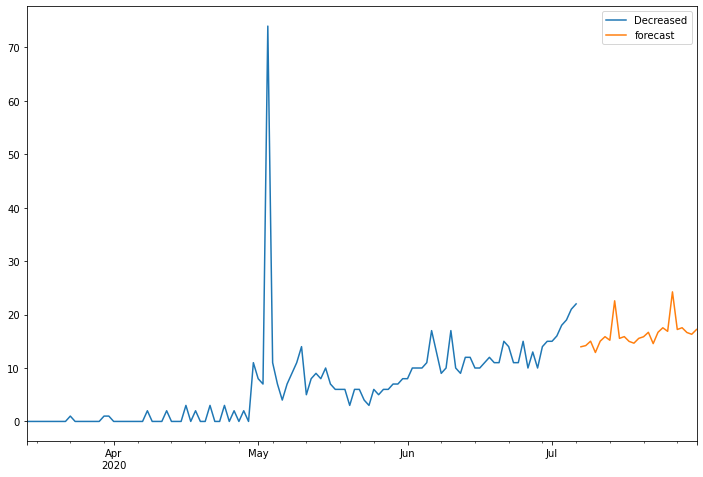

In [41]:
future_df[[para, 'forecast']].plot(figsize=(12, 8))

In [42]:
dicttt = {f'Future_Predicted_{para}':future_pred}
dicttt

{'Future_Predicted_Decreased': 2020-07-07    13.974616
 2020-07-08    14.196198
 2020-07-09    15.016071
 2020-07-10    12.904359
 2020-07-11    15.023179
 2020-07-12    15.865033
 2020-07-13    15.199293
 2020-07-14    22.578354
 2020-07-15    15.549485
 2020-07-16    15.874924
 2020-07-17    14.978982
 2020-07-18    14.648577
 2020-07-19    15.549455
 2020-07-20    15.851043
 2020-07-21    16.682045
 2020-07-22    14.568850
 2020-07-23    16.688969
 2020-07-24    17.530660
 2020-07-25    16.865284
 2020-07-26    24.252371
 2020-07-27    17.211507
 2020-07-28    17.538387
 2020-07-29    16.644734
 2020-07-30    16.313969
 2020-07-31    17.211476
 Freq: D, dtype: float64}

In [43]:
future_predicted_df = pd.DataFrame(dicttt)
future_predicted_df

,Future_Predicted_Decreased
2020-07-07,13.974616
2020-07-08,14.196198
2020-07-09,15.016071
2020-07-10,12.904359
2020-07-11,15.023179
2020-07-12,15.865033
2020-07-13,15.199293
2020-07-14,22.578354
2020-07-15,15.549485
2020-07-16,15.874924


In [44]:
# future_predicted_df.index.names = ['Date']
# future_predicted_df.index.freq = 'D'
# future_predicted_df.to_csv('Future_Predicted_WB.csv')

future_predicted_csv = pd.read_csv('Future_Predicted_WB.csv')

future_predicted_csv.Date = pd.to_datetime(future_predicted_csv.Date)
future_predicted_csv.set_index('Date', inplace=True)
future_predicted_csv.index.freq = 'D'
# print(future_predicted_csv)
# future_predicted_csv = pd.concat([future_predicted_csv,future_predicted_df],axis=1,ignore_index=True)
future_predicted_csv = pd.merge(future_predicted_csv, future_predicted_df, left_index=True, right_index=True, how='outer')
# predicted_csv = predicted_csv.join(predicted_df, how='outer')
print(future_predicted_csv)
future_predicted_csv.to_csv('Future_Predicted_WB.csv')

            Future_Predicted_Confirmed  Future_Predicted_Recovered  \
Date                                                                 
2020-07-07                  570.970527                  713.927595   
2020-07-08                  537.144913                  595.852341   
2020-07-09                  551.713719                  776.791823   
2020-07-10                  550.737129                  673.851855   
2020-07-11                  599.214309                  652.525889   
2020-07-12                  689.027049                  756.801374   
2020-07-13                  603.845634                  717.227866   
2020-07-14                  568.088346                  727.450418   
2020-07-15                  619.701840                  721.233565   
2020-07-16                  575.800544                  708.850073   
2020-07-17                  643.706566                  703.294211   
2020-07-18                  615.281961                  697.603655   
2020-07-19          